## Marmousi2 model 

Martin, G. S., Wiley, R., & Marfurt, K. J. (2006). Marmousi2: An elastic upgrade for Marmousi. The leading edge, 25(2), 156-166.

The raw data can be downloaded from [this website](http://www.agl.uh.edu/downloads/downloads.htm)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp2d, RectBivariateSpline
import scipy.signal
import scipy.io
import obspy
import os

In [52]:
in_dir = "./models_raw/"
out_dir = "./models"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [53]:
def calc_dx_dt(f0, v):
    dx = v * 1/f0 / 10
    dy = dx
    dt = dx / v / 3.5
    return dx, dt

In [54]:
def ricker(f, dt):
    # nt = np.around(10/f/dt)
    # src = scipy.signal.ricker(nt, a=1/f0/dt)
    T = np.sqrt(20) / (np.pi * f)
    t = np.arange(-T, T, dt) 
    src = (1-2*np.pi**2*f**2*t**2)*np.exp(-np.pi**2*f**2*t**2) * 1e6
    return src

In [55]:
def gaussian(f, dt):
    # nt = np.around(10/f/dt)
    # src = scipy.signal.ricker(nt, a=1/f0/dt)
    T = np.sqrt(15) / (np.pi * f)
    t = np.arange(-T, T, dt) 
#     src = np.sqrt(2*np.pi)*f*np.exp(-2*np.pi**2*f**2*t**2)
    src = np.exp(-2*np.pi**2*f**2*t**2) * 1e6
    return src

In [56]:
def extract_data(meta):
    data = []
    for trace in meta:
        data.append(trace.data)
    return np.array(data)

In [57]:
def load_marmousi_model():
    if not os.path.exists(os.path.join(in_dir, "vp_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/vp_marmousi-ii.segy.gz", in_dir))
    if not os.path.exists(os.path.join(in_dir, "vs_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/vs_marmousi-ii.segy.gz", in_dir))
    if not os.path.exists(os.path.join(in_dir, "density_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/density_marmousi-ii.segy.gz", in_dir))
    meta = obspy.read(os.path.join(in_dir, "vs_marmousi-ii.segy.gz"), format='segy')
    vs = extract_data(meta) * 1e3 #m/s^2
    meta = obspy.read(os.path.join(in_dir, "vp_marmousi-ii.segy.gz"), format='segy')
    vp = extract_data(meta) * 1e3 #m/s^2
    meta = obspy.read(os.path.join(in_dir, "density_marmousi-ii.segy.gz"), format='segy')
    rho = extract_data(meta) * 1e3 #kg/m^3
    
    x_range = [0, 17000] #m
    y_range = [0, 3500] #m
    nx, ny = vp.shape
    x = np.linspace(x_range[0], x_range[1], nx)
    y = np.linspace(y_range[0], y_range[1], ny)

    marmousi_model = {'vp': vp, 'vs':vs, 'rho':rho,
                      'x': x, 'y': y, 
                      'dx': x[1] - x[0], 'dy': y[1] - y[0]}
    
    return marmousi_model

marmousi_model = load_marmousi_model()

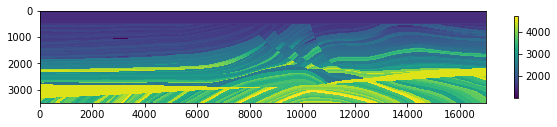

In [58]:
plt.figure(figsize=(10,5))
plt.pcolormesh(marmousi_model["x"][::10], marmousi_model["y"][::10], marmousi_model["vp"][::10,::10].T)
plt.axis("scaled")
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.3)
plt.show()

In [59]:
def resample_model(x, y, model):
    
    ratio_x = (x[1] - x[0])/(model['x'][1] - model['x'][0])
    ratio_y = (y[1] - y[0])/(model['y'][1] - model['y'][0])
    ratio = 3
    vp = gaussian_filter(model['vp'], [ratio_x/ratio, ratio_y/ratio], mode='reflect')
    vs = gaussian_filter(model['vs'], [ratio_x/ratio, ratio_y/ratio], mode='reflect')
    rho = gaussian_filter(model['rho'], [ratio_x/ratio, ratio_y/ratio], mode='reflect')
    
    vp = interp2d(model['y'], model['x'], vp, kind='linear')(y, x)
    vs = interp2d(model['y'], model['x'], vs, kind='linear')(y, x)
    rho = interp2d(model['y'], model['x'], rho, kind='linear')(y, x)
    
    new_model = {"vp":vp, "vs":vs, "rho": rho, "x":x, "y":y}
    new_model['dx'] = x[1] - x[0]
    new_model['dy'] = y[1] - y[0]
    
    return new_model

In [60]:
f0 = 6
vp0 = np.max(marmousi_model['vp'])
dx, dt = calc_dx_dt(f0*3, vp0)
dy = dx
n_pml = 12
x_range = [4000, 14500]
y_range = [0, 3500]
t_range = [0, np.sqrt((x_range[1] - x_range[0])**2 + (y_range[1] - y_range[0])**2)/np.mean(marmousi_model['vp']) * 1.6]
x = np.arange(x_range[0], x_range[1], dx)
y = np.arange(y_range[0], y_range[1], dy)
t = np.arange(t_range[0], t_range[1], dt)
nx = len(x)
ny = len(y)
nt = len(t)
src_rcv_depth = n_pml + 3
mask_extra_detph = 5

print(f"nx = {nx}, ny = {ny}, nt = {nt}")
print(f"dx = {dx:.2f} m, dy = {dy:.2f} m, dt = {dt:.2e} s")

nx = 403, ny = 135, nt = 4176
dx = 26.11 m, dy = 26.11 m, dt = 1.59e-03 s


In [61]:
model = resample_model(x, y, marmousi_model)

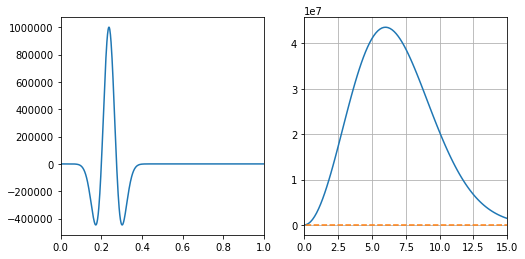

In [62]:
vec = np.zeros(nt)
vec_ricker = ricker(f0, dt)
# vec_ricker = gaussian(f0, dt)
vec[:len(vec_ricker)] = vec_ricker[:len(vec)]
t = np.arange(len(vec))*dt

f_vec = np.fft.fft(vec)
f = np.fft.fftfreq(len(vec), dt)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(t, vec)
plt.xlim([0, 1])
plt.subplot(122)
plt.plot(f[:len(f)//2], np.abs(f_vec)[:len(f)//2])
plt.plot(plt.xlim(), [0, 0], '--')
plt.xlim([0, 15])
plt.grid("major")
plt.show()

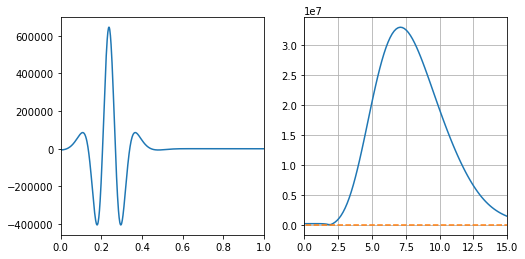

In [63]:
vec = np.zeros(nt)
vec_ricker = ricker(f0, dt)
# vec_ricker = gaussian(f0, dt)

vec[:len(vec_ricker)] = vec_ricker[:len(vec)]
t = np.arange(len(vec))*dt

sos = scipy.signal.butter(2, 5, "hp", fs=np.round(1/dt), output='sos')
# sos = scipy.signal.cheby1(4, 0.1, 6, "hp", fs=np.round(1/dt), output='sos')
filt_vec = scipy.signal.sosfilt(sos, vec)
filt_vec = scipy.signal.sosfilt(sos, filt_vec[::-1])[::-1]

f_vec = np.fft.fft(filt_vec)
f = np.fft.fftfreq(len(filt_vec), dt)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(t, filt_vec)
plt.xlim([0, 1])
plt.subplot(122)
plt.plot(f[:len(f)//2], np.abs(f_vec)[:len(f)//2])
plt.plot(plt.xlim(), [0, 0], '--')
plt.xlim([0, 15])
plt.grid("major")
plt.show()

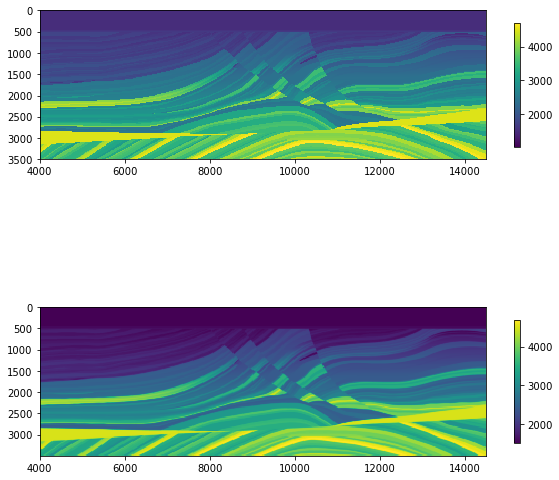

In [64]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.pcolormesh(marmousi_model["x"][::10], marmousi_model["y"][::10], marmousi_model["vp"][::10,::10].T)
plt.axis("scaled")
plt.xlim(x_range)
plt.ylim(y_range)
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.5)

plt.subplot(212)
plt.pcolormesh(model["x"], model["y"], model["vp"].T)
plt.axis("scaled")
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.5)
plt.show()

In [65]:
def add_source(nsrc, nx, nt, dt, f0=5, n_pml=0):
    src_list = []
    src_ix = np.round(np.linspace(1+2*n_pml+nx/20, nx-2*n_pml-nx/20, nsrc)).astype('int')
    src_iy = np.ones_like(src_ix) * src_rcv_depth
#     src_vec = np.zeros(nt)
#     vec = 1e7*ricker(f0, dt)
#     src_vec[:len(vec)] = vec[:nt]
    src_vec = filt_vec
    for i in range(nsrc):
        tmp = {"ix": src_ix[i], "iy": src_iy[i], "type": 0, "vec": src_vec}
        src_list.append(tmp)
    return src_list

nsrc = 8
source_list = add_source(nsrc, nx, nt, dt, f0, n_pml)

In [66]:
def add_receiver(nrcv, nsrc, nx, n_pml=0, full=False):
    rcv = {}
    if full:
        rcv['ix'] = np.arange(n_pml, nx-n_pml+1).astype('int')
    else:
        rcv['ix'] = np.round(np.linspace(1+n_pml, nx-n_pml, nrcv)).astype('int')
    rcv['iy'] = np.ones_like(rcv['ix']) * src_rcv_depth
    rcv['type'] = np.ones_like(rcv['ix'])
    rcv_list = [rcv] * nsrc
    return rcv_list

receiver_list = add_receiver(int(vp0/f0/dx)*3, nsrc, nx, n_pml, True)

In [67]:
def get_smooth_model(model, src):
    if mask_extra_detph > 0:
        vp = model['vp'].copy()
        vp[:,src_rcv_depth+mask_extra_detph:] = gaussian_filter(model['vp'][:, src_rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
        vs = model['vs'].copy()
        vs[:,src_rcv_depth+mask_extra_detph:] = gaussian_filter(model['vs'][:, src_rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
        rho = model['rho'].copy()
        rho[:,src_rcv_depth+mask_extra_detph:] = gaussian_filter(model['rho'][:, src_rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
    else:
        vp = model['vp'].copy()
        vp = gaussian_filter(model['vp'], [10,10], mode='reflect')
        vs = model['vs'].copy()
        vs = gaussian_filter(model['vs'], [10,10], mode='reflect')
        rho = model['rho'].copy()
        rho = gaussian_filter(model['rho'], [10,10], mode='reflect')
    
    # 1D model
    vp = np.mean(vp, axis=0, keepdims=True).repeat(nx, axis=0)
    vs = np.mean(vs, axis=0, keepdims=True).repeat(nx, axis=0)
    rho = np.mean(rho, axis=0, keepdims=True).repeat(nx, axis=0)
    vp[:,:src_rcv_depth+mask_extra_detph] = model['vp'][:,:src_rcv_depth+mask_extra_detph]
    vs[:,:src_rcv_depth+mask_extra_detph] = model['vs'][:,:src_rcv_depth+mask_extra_detph]
    rho[:,:src_rcv_depth+mask_extra_detph] = model['rho'][:,:src_rcv_depth+mask_extra_detph]
    mask = np.ones_like(vp)
    mask[:,:src_rcv_depth+mask_extra_detph]=0
    new_model = {"vp":vp, "vs":vs, "rho":rho, "x":x, "y":y, "dx":dx, "dy":dy, "mask":mask}
    return new_model

smooth_model = get_smooth_model(model, source_list[0])

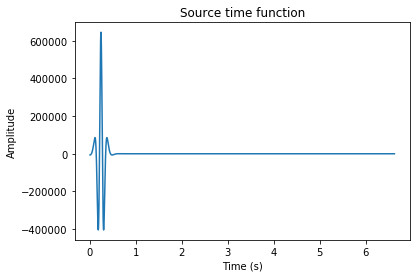

In [68]:
plt.figure()
plt.plot(t, source_list[0]['vec'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("Source time function")
plt.show()

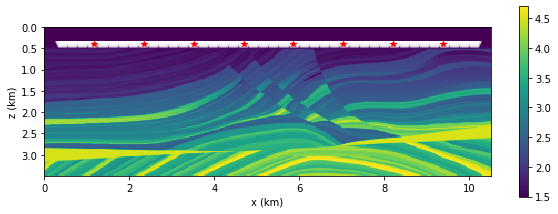

In [69]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, model['vp'].T/1e3)
plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "marmoursi-model-vp.png"))
plt.show()

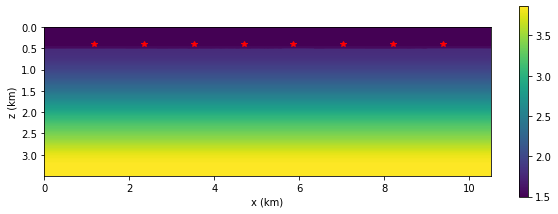

In [70]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, smooth_model['vp'].T/1e3)
# plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "marmoursi-model-smooth-vp.png"))
plt.show()

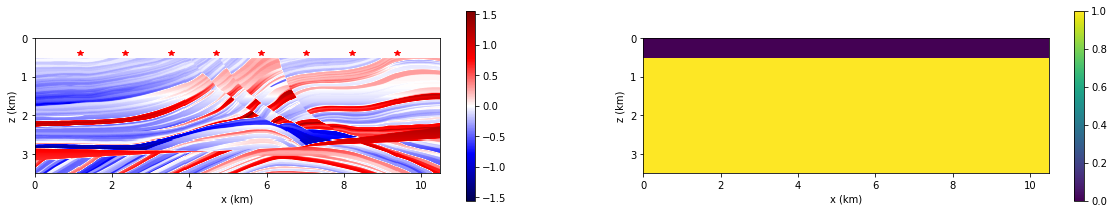

In [71]:
plt.figure(figsize=(20,7))
plt.subplot(121)
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
vmax = np.max(np.abs((model['vp'] - smooth_model['vp']).T/1e3))
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, (model['vp'] - smooth_model['vp']).T/1e3, cmap="seismic", vmax=vmax, vmin=-vmax)
# plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.subplot(122)
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, smooth_model["mask"].T)
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "marmoursi-model-diff-vp.png"))
plt.show()

In [72]:
scipy.io.savemat(os.path.join(out_dir, 'marmousi2-model-true-large.mat'),
         {"vp" : model['vp'], 
         "vs" : model['vs'], 
         "rho" : model['rho'], 
         "source" : source_list,
         "receiver" : receiver_list,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})

In [73]:
scipy.io.savemat(os.path.join(out_dir, 'marmousi2-model-smooth-large.mat'),
         {"vp" : smooth_model['vp'], 
         "vs" : smooth_model['vs'], 
         "rho" : smooth_model['rho'], 
         "mask": smooth_model['mask'], 
         "source" : source_list,
         "receiver" : receiver_list,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})